# Описание проекта

Заказчик поставил задачу прогнозирования спроса на товар или категорию товаров. 

**План исследования**

1. Провести исследовательский анализ данных (EDA) (определить структуру данных найти возможные зависимости спроса от товаров)
2. Построить модель прогноза спроса 
3. Выделить зависимость спроса от цены и построить кривые эластичности

**Описание данных**

Было предоставлено несколько датасетов с следующим содержанием: 
1. `beer_sales_data.parquet` - продажи пива

2. `cig_sales_data.parquet` - продажи сигарет
3. `ana_sales_data.parquet` - продажи анальгетиков
4. `demographic_data.parquet` - данные демографии и магазина
5. `beer_upc.parquet` - таблица с описанием товара пиво 
6. `cig_upc.parquet` - таблица с описанием товара сигареты
7. `ana_upc.parquet` - таблица с описанием товара анальгетики

На основе чего можно выделить 3 типа предоставленных таблиц: 
sales, demographic, upc: 

**Данные таблиц sales**
1. `upc` - upc number (универсальный код товара)

2. `store` - store number (номер магазина)
3. `week` - week number
4. `move` - Number of unit sold (количество проданных товаров)
5. `price` - Retail Price (цена продажи)
6. `qty` - Number of item bundled together (количество товаров, которые есть в магазине)
7. `sale` - Sale code (B,C,S) This variable indicates whether the product was sold on a promotion that week. A code of 'B' indicates a Bonus Buy, 'C' indicates a Coupon, 'S' indicate a simple price reduction.

**Данные таблиц upc**

1. `'com_code'` - not important

2. `'upc'` - upc number
3. `'descrip'` - Product Name
4. `'size'` - Product size
5. `'case'` - not important
6. `'nitem'` - Number of items in a case

**Данные таблицы demographic**

1. `'store'` - store number

2. `'age60'` - % Population over age 60
3. `'age9'` - % Population under age 9
4. `'educ'` - % College Graduates
5. `'ethnic'` - % Blacks & Hispanics
6. `'income'` - Log of Median Income
7. `'hhlarge'` - % of households with 5 or more persons
8. `'workwom'` - % Working Women with full-time jobs
9. `'hval150'` - % of Households with Value over $150,000
10. `'sstrdist'` - distance to the nearest warehouse store
11. `'sstrvol'` - ratio of sales of this store to the nearest warehouse store
12. `'cpdist5'` - average distance in miles to the nearest 5 supermarkets
13. `'cpwvol5'` - ratio of sales of this store to the average of the nearest five stores



*В этом исследовании будет проводится прогноз на спрос анальгетиков*

# Выгрузка и ознакомление с данными 

In [1]:
# Необходимые импорты и настройки
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from datetime import datetime, timezone, timezone, timedelta

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

# Преобразование и обработка данных
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import (train_test_split, 
                                     TimeSeriesSplit, 
                                    GridSearchCV)
from sklearn.preprocessing import (StandardScaler, 
                                   MinMaxScaler, 
                                  OneHotEncoder)
from sklearn.impute import SimpleImputer
from sklearn.metrics import root_mean_squared_error

# Импорт моделей
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
 
# Сброс ограничений на число столбцов
pd.set_option('display.max_columns', None)
 
# Сброс ограничений на количество символов в записи
pd.set_option('display.max_colwidth', None)

In [2]:
# Преобразование в датафреймы
ana_sales = pd.read_parquet('C:/Users/79952/Desktop/datasets_avtomakon/ana_sales_data.parquet')
ana_upc = pd.read_parquet('C:/Users/79952/Desktop/datasets_avtomakon/ana_upc.parquet')
beer_sales = pd.read_parquet('C:/Users/79952/Desktop/datasets_avtomakon/beer_sales_data.parquet')
beer_upc = pd.read_parquet('C:/Users/79952/Desktop/datasets_avtomakon/beer_upc.parquet')
cig_sales = pd.read_parquet('C:/Users/79952/Desktop/datasets_avtomakon/cig_sales_data.parquet')
cig_upc = pd.read_parquet('C:/Users/79952/Desktop/datasets_avtomakon/cig_upc.parquet')
demographic = pd.read_parquet('C:/Users/79952/Desktop/datasets_avtomakon/demographic_data.parquet')

In [3]:
# Вывод данных
datasets = {'ana_sales': ana_sales, 
           'ana_upc': ana_upc, 
           'beer_sales': beer_sales, 
           'beer_upc': beer_upc,
           'cig_sales': cig_sales,
           'cig_upc': cig_upc,
           'demographic': demographic}

for dataset_name, dataset in datasets.items(): 
    print('\n', '-'*40, f'Общая информация датасета {dataset_name}', '-'*40, '\n')
    dataset.info()
    print('\n', '-'*40, f'Содержание датасета {dataset_name}', '-'*40)
    display(dataset.head())


 ---------------------------------------- Общая информация датасета ana_sales ---------------------------------------- 

<class 'pandas.core.frame.DataFrame'>
Index: 7241655 entries, 0 to 7339216
Data columns (total 7 columns):
 #   Column  Dtype  
---  ------  -----  
 0   store   int64  
 1   upc     int64  
 2   week    int64  
 3   move    int64  
 4   qty     int64  
 5   price   float64
 6   sale    object 
dtypes: float64(1), int64(5), object(1)
memory usage: 442.0+ MB

 ---------------------------------------- Содержание датасета ana_sales ----------------------------------------


,store,upc,week,move,qty,price,sale
0,76,1192603016,306,0,1,0.00,None
1,76,1192603016,307,1,1,2.99,None
2,76,1192603016,308,0,1,0.00,None
3,76,1192603016,309,0,1,0.00,None
4,76,1192603016,310,0,1,0.00,None



 ---------------------------------------- Общая информация датасета ana_upc ---------------------------------------- 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 641 entries, 0 to 640
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   com_code  641 non-null    int64 
 1   upc       641 non-null    int64 
 2   descrip   641 non-null    object
 3   size      641 non-null    object
 4   case      641 non-null    int64 
 5   nitem     641 non-null    int64 
dtypes: int64(4), object(2)
memory usage: 30.2+ KB

 ---------------------------------------- Содержание датасета ana_upc ----------------------------------------


,com_code,upc,descrip,size,case,nitem
0,953,1192603016,CAFFEDRINE CAPLETS 1,16 CT,6,7342431
1,953,1192662108,SLEEPINAL SOFTGEL,8 CT,6,7333311
2,953,1650001020,NERVINE TABS,30 CT,1,8430820
3,953,1650001022,NERVINE SLEEP AID,12 CT,1,8430840
4,953,1650004106,ALKA-SELTZER GOLD,20 CT,1,8430880



 ---------------------------------------- Общая информация датасета beer_sales ---------------------------------------- 

<class 'pandas.core.frame.DataFrame'>
Index: 3967720 entries, 0 to 3990671
Data columns (total 7 columns):
 #   Column  Dtype  
---  ------  -----  
 0   store   int64  
 1   upc     int64  
 2   week    int64  
 3   move    int64  
 4   qty     int64  
 5   price   float64
 6   sale    object 
dtypes: float64(1), int64(5), object(1)
memory usage: 242.2+ MB

 ---------------------------------------- Содержание датасета beer_sales ----------------------------------------


,store,upc,week,move,qty,price,sale
0,2,294,298,11,1,2.62,None
1,2,294,299,9,1,2.51,None
2,2,294,300,6,1,2.49,None
3,2,294,301,5,1,2.99,None
4,2,294,302,1,1,2.49,None



 ---------------------------------------- Общая информация датасета beer_upc ---------------------------------------- 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790 entries, 0 to 789
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   com_code  790 non-null    int64 
 1   upc       790 non-null    int64 
 2   descrip   790 non-null    object
 3   size      790 non-null    object
 4   case      790 non-null    int64 
 5   nitem     790 non-null    int64 
dtypes: int64(4), object(2)
memory usage: 37.2+ KB

 ---------------------------------------- Содержание датасета beer_upc ----------------------------------------


,com_code,upc,descrip,size,case,nitem
0,27,294,BEER LIMIT,12/12O,2,9990180
1,26,307,HEINEKEN KINGSIZE CA,259 OZ,1,9490410
2,27,710,BUDWEISER BEER,24/12O,1,9402300
3,27,711,BUDWEISER DRY BEER,24/12O,1,9402650
4,27,712,BUDWEISER LIGHT BEER,24/12O,1,9402600



 ---------------------------------------- Общая информация датасета cig_sales ---------------------------------------- 

<class 'pandas.core.frame.DataFrame'>
Index: 5331369 entries, 0 to 5398196
Data columns (total 7 columns):
 #   Column  Dtype  
---  ------  -----  
 0   store   int64  
 1   upc     int64  
 2   week    int64  
 3   move    int64  
 4   qty     int64  
 5   price   float64
 6   sale    object 
dtypes: float64(1), int64(5), object(1)
memory usage: 325.4+ MB

 ---------------------------------------- Содержание датасета cig_sales ----------------------------------------


,store,upc,week,move,qty,price,sale
0,8,190,194,0,1,0.00,None
1,8,190,195,2,1,21.51,None
2,8,190,196,0,1,0.00,None
3,8,190,197,0,1,0.00,None
4,8,190,198,0,1,0.00,None



 ---------------------------------------- Общая информация датасета cig_upc ---------------------------------------- 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 942 entries, 0 to 941
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   com_code  942 non-null    int64 
 1   upc       942 non-null    int64 
 2   descrip   942 non-null    object
 3   size      942 non-null    object
 4   case      942 non-null    int64 
 5   nitem     942 non-null    int64 
dtypes: int64(4), object(2)
memory usage: 44.3+ KB

 ---------------------------------------- Содержание датасета cig_upc ----------------------------------------


,com_code,upc,descrip,size,case,nitem
0,700,190,KING CARTON CIGS (PL,1 CT,1,86040
1,700,191,100'S CARTON CIGS (P,1 CT,1,86060
2,705,193,25 CT SINGLE PACK CI,1 CT,8,80080
3,705,194,GENERIC SINGLE,1 CT,10,80020
4,700,195,KING CARTON PRICE VA,1 CT,1,86050



 ---------------------------------------- Общая информация датасета demographic ---------------------------------------- 

<class 'pandas.core.frame.DataFrame'>
Index: 107 entries, 1 to 107
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   store     107 non-null    float64
 1   age60     97 non-null     float32
 2   age9      97 non-null     float32
 3   educ      97 non-null     float32
 4   ethnic    97 non-null     float32
 5   income    97 non-null     float32
 6   hhlarge   97 non-null     float32
 7   workwom   97 non-null     float32
 8   hval150   97 non-null     float32
 9   sstrdist  85 non-null     float32
 10  sstrvol   85 non-null     float32
 11  cpdist5   85 non-null     float32
 12  cpwvol5   85 non-null     float32
dtypes: float32(12), float64(1)
memory usage: 6.7 KB

 ---------------------------------------- Содержание датасета demographic ----------------------------------------


,store,age60,age9,educ,ethnic,income,hhlarge,workwom,hval150,sstrdist,sstrvol,cpdist5,cpwvol5
1,2.0,0.232865,0.117509,0.248935,0.114280,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.927280,0.376927
2,4.0,0.262030,0.095090,0.220789,0.062161,10.646972,0.088123,0.362122,0.522236,2.373200,1.000000,1.104470,0.772489
3,5.0,0.117368,0.141433,0.321226,0.053875,10.922371,0.103092,0.410568,0.535883,3.801998,0.681818,1.600573,0.736307
4,8.0,0.252394,0.123155,0.095173,0.035243,10.597010,0.131750,0.283075,0.054227,2.636333,1.500000,2.905384,0.641016
5,9.0,0.269119,0.103503,0.222172,0.032619,10.787151,0.096830,0.358995,0.505747,1.103279,0.666667,1.820474,0.441268


**Вывод**: данные успешно выгружены и готовы к следующим этапам. Как видно данные уже ресемплированны по неделям. 

# Предобработка данных

Типы данных во всех таблицах корректны. Идем далее

## Корректировка признаков

In [4]:
ana_upc['size'].unique()

array(['16 CT', '8 CT', '30 CT', '12 CT', '20 CT', '36 CT', '50 CT',
       '24 CT', '100 CT', '1 CT', '250 CT', '32 CT', '175 CT', '.5OZ.',
       '40 CT', '2-100', '60 CT', '4 OZ', '500 CT', '.5 OZ', '8 OZ',
       '10 CT', '2-30 C', '2 OZ', '4 CT', '4CT', '28 CT', '2 CT',
       '1000 C', '165 CT', '2/24 C', '130 CT', '65 CT', '100CT.',
       '2/50 C', '125 CT', '72 CT', '2-24 C', '1 OZ', '125CT.', '6 CT',
       '150 CT', '48 CT', '200 CT', '75 CT', '85 CT', '15 CT', '45 CT',
       '300 CT', '30CT.', '24+6 C', '100+50', '200CT.', '60CT.', '1.16 O',
       '120 CT', '24+24C', '80 CT', '50+15', '100+30', '6 OZ', '140CT.',
       'ASST', '24CT.', '50CT.', '39 CT', '50 + 2', '24+12', '50+24',
       '3 OZ', '90 CT', '60+20C', '16+8 C', '2.5 OZ'], dtype=object)

In [5]:
beer_upc['size'].unique()

array(['12/12O', '259 OZ', '24/12O', '30/12O', '750 ML', '16.9 O',
       '6/12 O', '21.6 O', '32 OZ', '6/16 O', '6/12OZ', '40 OZ', '8/7OZ',
       '6/7 O', '5.16GA', '18/12O', '8/12 O', '22OZ.', '22 OZ', '20/12O',
       '12/11.', '4/14.9', '24 OZ', '25 OZ', '661 OZ', '15/120', '4/12 O',
       '24/16O', '30/12', '16/12O', '6/11 O', '3/22OZ', '21 OZ', '2/16 O',
       '20 OZ', '4/15 O', '6/10 O', '10/12O', '6/11.2', '6/11.1'],
      dtype=object)

In [6]:
cig_upc['size'].unique()

array(['1 CT', '10 PK', 'PACK', '10 CT', '2PK', '5 CT', '10 EA', '1.2 O',
       '5 EA', '4 CT', '2/1.5O', '12 OZ', '50 CT', '.75 OZ'], dtype=object)

Как видно размер товара представлен по разному (иногда информация представлена в каратах(CT) или унциях(OZ) и так далее). 
Данный признак не является особо информативным, так как не определяет спрос на определенных продукт. Также заказчик пометил колонки `com_code` и `case` как `not important`. Сбросим все перечисленные столбцы

In [7]:
lst = [ana_upc, beer_upc, cig_upc]
ana_upc, beer_upc, cig_upc = [l.drop(['size', 'com_code', 'case'], axis=1) for l in lst]

In [8]:
ana_upc.head()

,upc,descrip,nitem
0,1192603016,CAFFEDRINE CAPLETS 1,7342431
1,1192662108,SLEEPINAL SOFTGEL,7333311
2,1650001020,NERVINE TABS,8430820
3,1650001022,NERVINE SLEEP AID,8430840
4,1650004106,ALKA-SELTZER GOLD,8430880


Признаки в датасетах `upc` скоррекитрованны

Рассмотрим признак `sale` в каждом датасете. Его значениями может быть только `B,C,S` или `None`

In [9]:
ana_sales['sale'].unique()

array([None, 'B', 'S', 'G', 'C'], dtype=object)

In [10]:
beer_sales['sale'].unique()

array([None, 'B', 'S', 'C'], dtype=object)

In [11]:
cig_sales['sale'].unique()

array([None, 'S'], dtype=object)

Удалим значения `G` из датасета `ana_sales`

In [12]:
ana_sales = ana_sales.query('sale != "G"')

In [13]:
ana_sales['sale'].unique()

array([None, 'B', 'S', 'C'], dtype=object)

**Вывод**: уникальные значения обработаны

## Обработка пропусков 

In [14]:
# поиск пропусков
for dataset_name, dataset in datasets.items():
    print(f'Количество пропусков в датасете {dataset_name}')
    print(dataset.isna().sum())
    print('-'*50)

Количество пропусков в датасете ana_sales
store          0
upc            0
week           0
move           0
qty            0
price          0
sale     6979032
dtype: int64
--------------------------------------------------
Количество пропусков в датасете ana_upc
com_code    0
upc         0
descrip     0
size        0
case        0
nitem       0
dtype: int64
--------------------------------------------------
Количество пропусков в датасете beer_sales
store          0
upc            0
week           0
move           0
qty            0
price          0
sale     3420284
dtype: int64
--------------------------------------------------
Количество пропусков в датасете beer_upc
com_code    0
upc         0
descrip     0
size        0
case        0
nitem       0
dtype: int64
--------------------------------------------------
Количество пропусков в датасете cig_sales
store          0
upc            0
week           0
move           0
qty            0
price          0
sale     5331348
dtype: int6

Были найдены пропуски в датасете `demographic`. Важным является то, что они составляют относительно большую долю от всего датасета (всего в датасете 107 записей). Необходимо рассмотреть их детальнее

In [15]:
demographic[demographic.isna().any(axis=1)]

,store,age60,age9,educ,ethnic,income,hhlarge,workwom,hval150,sstrdist,sstrvol,cpdist5,cpwvol5
9,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,39.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,46.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,55.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31,60.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69,108.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91,133.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93,136.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95,139.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Есть 2 вида пропусков: 
1. отстутсвуют вообще все данные по магазину (их придется сбросить полностью)
2. остутствуют данные связанные с дистанцией (вставим заглушку-медиану по всем магазинам)

In [16]:
demographic = demographic.dropna(subset='age60')

In [17]:
demographic[demographic.isna().any(axis=1)]

,store,age60,age9,educ,ethnic,income,hhlarge,workwom,hval150,sstrdist,sstrvol,cpdist5,cpwvol5
96,301.0,0.094037,0.179988,0.174966,0.029719,10.723421,0.183019,0.338504,0.465321,NaN,NaN,NaN,NaN
97,302.0,0.102426,0.162099,0.281232,0.074278,10.665764,0.123527,0.410053,0.245614,NaN,NaN,NaN,NaN
98,303.0,0.142001,0.188214,0.050421,0.589374,9.938372,0.214981,0.297891,0.004700,NaN,NaN,NaN,NaN
99,304.0,0.112221,0.115344,0.237379,0.345625,10.183881,0.078774,0.341639,0.676901,NaN,NaN,NaN,NaN
100,305.0,0.142966,0.165875,0.120727,0.022828,10.523392,0.127130,0.339649,0.179668,NaN,NaN,NaN,NaN
101,306.0,0.312928,0.094382,0.161354,0.026813,10.734373,0.093954,0.329120,0.422132,NaN,NaN,NaN,NaN
102,307.0,0.104416,0.181204,0.123701,0.070966,10.605247,0.146939,0.394064,0.136884,NaN,NaN,NaN,NaN
103,308.0,0.235498,0.120519,0.159787,0.185974,10.439542,0.113268,0.316430,0.290223,NaN,NaN,NaN,NaN
104,309.0,0.067192,0.200156,0.278103,0.204785,10.757754,0.152418,0.392109,0.406664,NaN,NaN,NaN,NaN
105,310.0,0.177015,0.134641,0.283289,0.045067,10.861496,0.100310,0.421429,0.594775,NaN,NaN,NaN,NaN


In [18]:
values = {'sstrdist': demographic['sstrdist'].median(), 
         'sstrvol': demographic['sstrvol'].median(), 
         'cpdist5': demographic['cpdist5'].median(), 
         'cpwvol5': demographic['cpwvol5'].median()}

demographic = demographic.fillna(value=values)

In [19]:
# Пропуски в demographic
demographic.isna().sum()

store       0
age60       0
age9        0
educ        0
ethnic      0
income      0
hhlarge     0
workwom     0
hval150     0
sstrdist    0
sstrvol     0
cpdist5     0
cpwvol5     0
dtype: int64

**Вывод**: пропуски успешно обработаны

## Обработка дубликатов

In [20]:
for dataset_name, dataset in datasets.items(): 
    print(f'Дубликаты датасета {dataset_name}: {dataset.duplicated().sum()}')

Дубликаты датасета ana_sales: 0
Дубликаты датасета ana_upc: 0
Дубликаты датасета beer_sales: 0
Дубликаты датасета beer_upc: 0
Дубликаты датасета cig_sales: 0
Дубликаты датасета cig_upc: 0
Дубликаты датасета demographic: 0


**Вывод**: явных дубликатов не обнаружено, предобработка данных окончена

# Первичный исследовательский анализ данных (EDA) 

В основном все имеющиеся данные являются количественными признаками. Гистограммы и боксплота для непрервных значений вполне хватит. Для категориальный признаков будем строить столбчатые графики. Разобъем исследовательский анализ на 4 этапа(по каждому датасету и отдельно демография). 

Анализ id магазинов и товаров проводить нет смысла

In [21]:
# Функция для исследовательского анализа количественных непрерывных признаков

def EDA(dataset, feature, bins=30, kde=True):
    
    print('Описательная статистика: ' + feature)
    display(dataset[feature].describe())
    
    plt.figure(figsize=(10,5))
    sns.histplot(data=dataset, x=feature, bins=bins, kde=kde)
    plt.title('Гистограмма признака: ' + feature)
    plt.xlabel(feature)
    plt.ylabel('Частота')
    plt.show()

    plt.figure(figsize=(10,2))
    sns.boxplot(data=dataset, x=feature)
    plt.title('Боксплот признака: ' + feature)
    plt.show()

In [22]:
# Функция для исследовательского анализа категориальных признаков
def EDA_cat(dataset, feature, rotation=0, figsize=(5,5)): 
    plt.figure(figsize=figsize)
    dataset[feature].value_counts().plot.bar()
    plt.title('График столбца: ' + feature)
    plt.ylabel('Частота')
    plt.xticks(rotation=rotation)
    plt.show()
    
    print(dataset[feature].value_counts())

## Датасеты `beer`

Описательная статистика: week


count    3.967720e+06
mean     2.364477e+02
std      8.410145e+01
min      9.100000e+01
25%      1.670000e+02
50%      2.360000e+02
75%      3.020000e+02
max      3.990000e+02
Name: week, dtype: float64

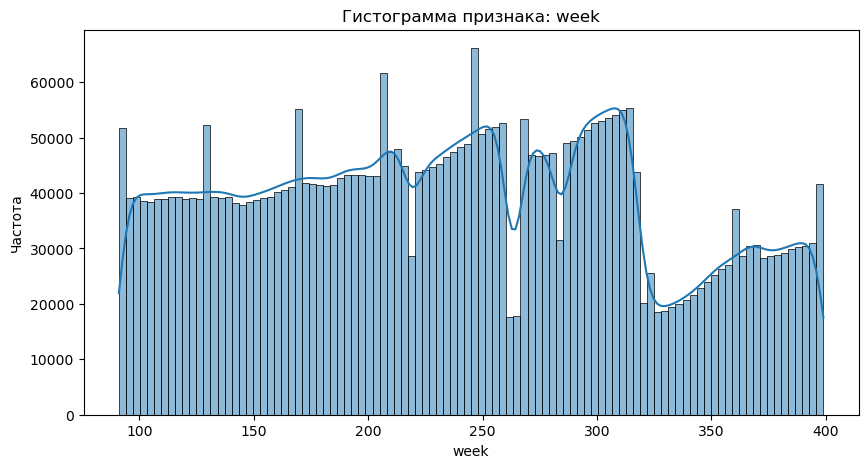

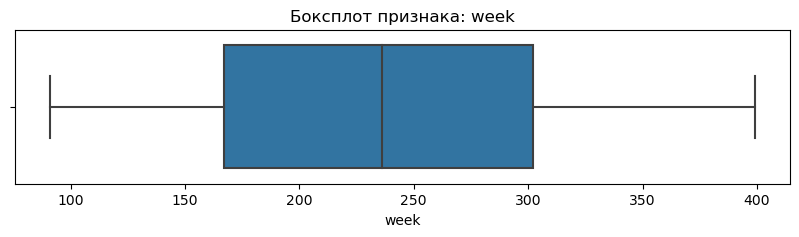

In [23]:
EDA(beer_sales, 'week', bins=100)

**Вывод**: наблюдается большой спад в наблюдениях на 325 неделе, скорее всего методика исследования в это время претерпеда значительные изменения 

Описательная статистика: move


count    3.967720e+06
mean     3.383864e+00
std      8.877261e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      3.000000e+00
max      7.690000e+02
Name: move, dtype: float64

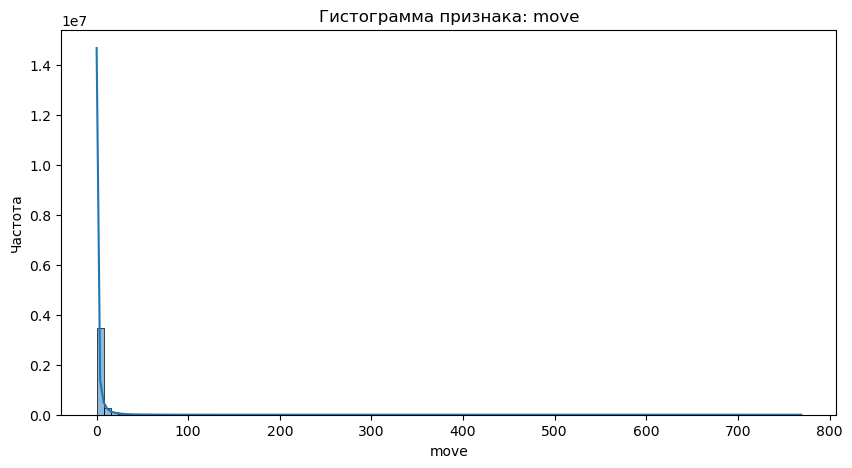

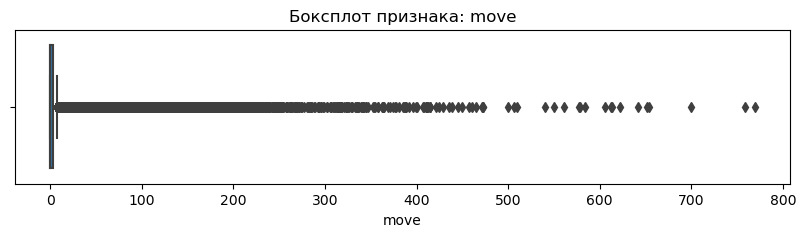

In [24]:
EDA(beer_sales, 'move', bins=100)

**Вывод**: боксплот показал наличие выбросов, скорее всего даже аномальных выбросов, так как количесво проданных товаров в размере 770 штук настораживает. Однако, скорее всего это связано с аномальным спросом на данную продукцию в определенное время

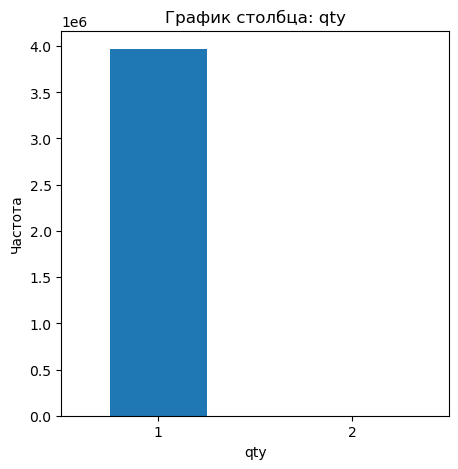

qty
1    3967676
2         44
Name: count, dtype: int64


In [25]:
EDA_cat(beer_sales, 'qty')

**Вывод**: `qty` - категориальный признак. Подавляющее количество проданного товара не входит в комплект

Описательная статистика: price


count    3.967720e+06
mean     2.819041e+00
std      3.422010e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      4.990000e+00
max      2.964000e+01
Name: price, dtype: float64

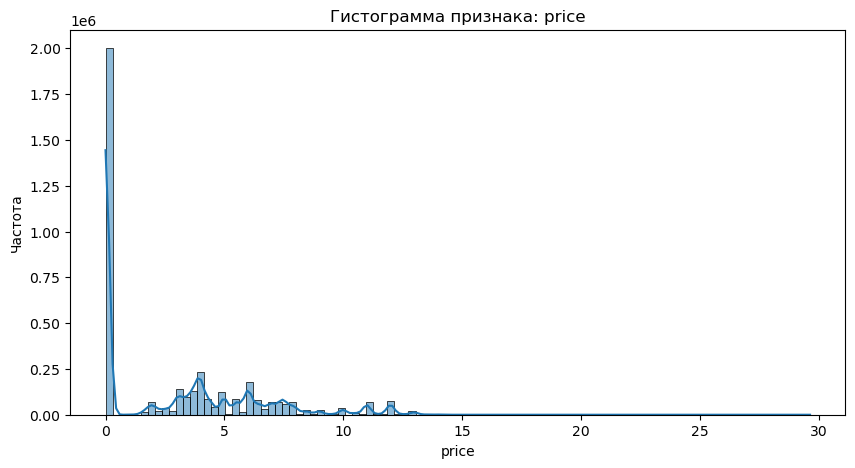

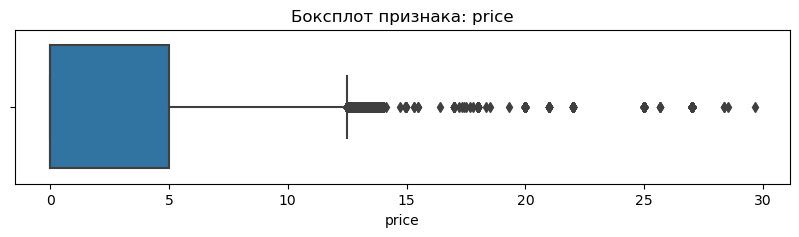

In [26]:
EDA(beer_sales, 'price', bins=100)

**Вывод**: Подавляющее количество розничных цен равны нулю, что является аномальным значением. Избавимся от нулей в розничной цене

In [27]:
beer_sales = beer_sales.query('price != 0')

Описательная статистика: price


count    1.966148e+06
mean     5.688873e+00
std      2.702808e+00
min      1.000000e-02
25%      3.790000e+00
50%      4.990000e+00
75%      7.050000e+00
max      2.964000e+01
Name: price, dtype: float64

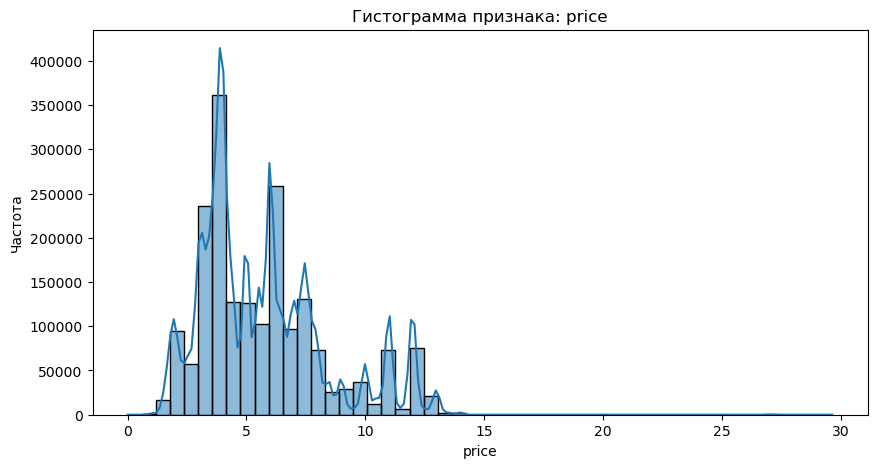

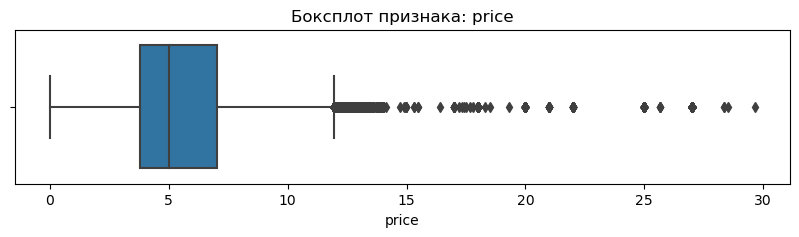

In [28]:
EDA(beer_sales, 'price', bins=50)

**Вывод**: аномальные значения исключены. Распределение напоминает нормальное

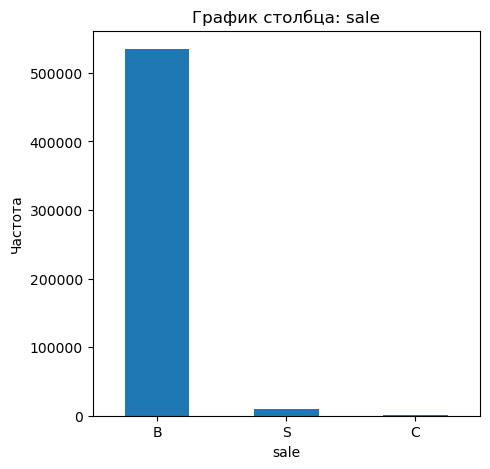

sale
B    534735
S      9688
C       333
Name: count, dtype: int64


In [29]:
EDA_cat(beer_sales, 'sale')

**Вывод**: Подавляющее количество акций проходило под кодом `B` (бонусная покупка)

## Датасет `ana`

In [30]:
ana_sales.head()

,store,upc,week,move,qty,price,sale
0,76,1192603016,306,0,1,0.00,None
1,76,1192603016,307,1,1,2.99,None
2,76,1192603016,308,0,1,0.00,None
3,76,1192603016,309,0,1,0.00,None
4,76,1192603016,310,0,1,0.00,None


Описательная статистика: week


count    7.241268e+06
mean     2.227485e+02
std      1.113187e+02
min      1.000000e+00
25%      1.310000e+02
50%      2.330000e+02
75%      3.180000e+02
max      3.990000e+02
Name: week, dtype: float64

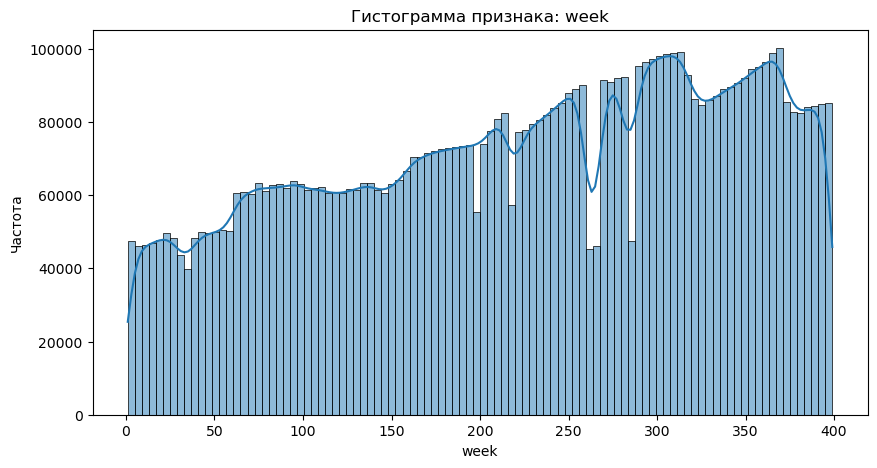

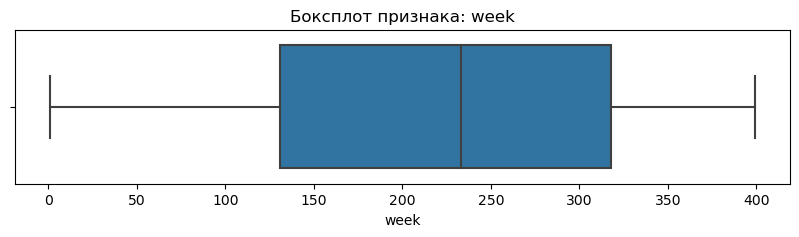

In [31]:
EDA(ana_sales, 'week', bins=100)

**Вывод**: наблюдается тенденция роста количества наблюдений с каждый годом. 

Описательная статистика: move


count    7.241268e+06
mean     1.108502e+00
std      2.426539e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      9.630000e+02
Name: move, dtype: float64

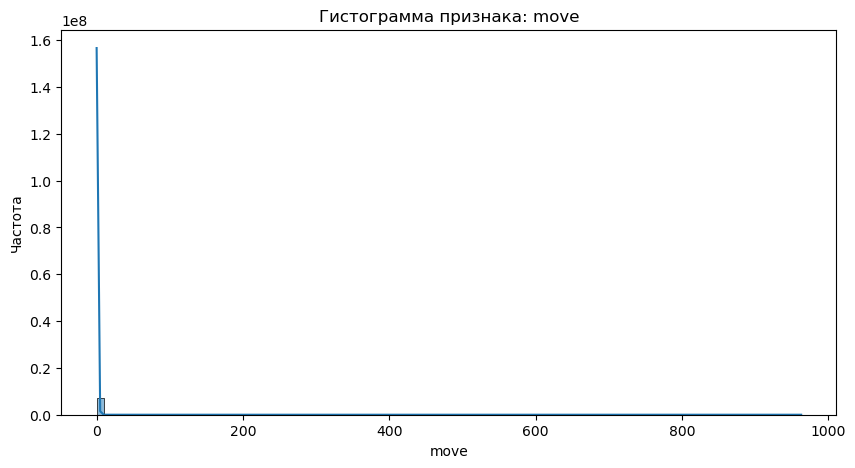

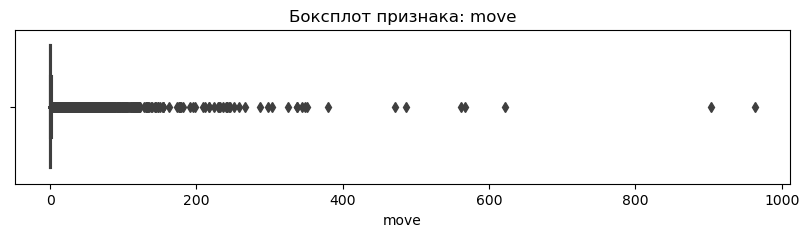

In [32]:
EDA(ana_sales, 'move', bins=100)

**Вывод**: ситуация аналогична с датасетом выше

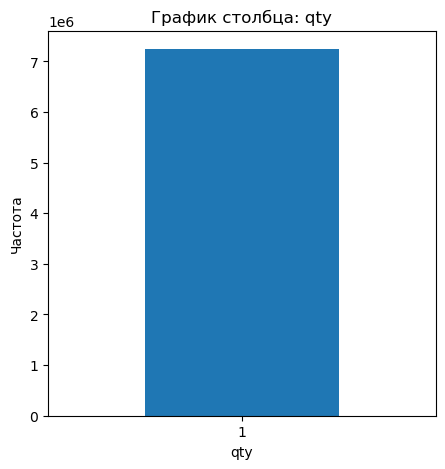

qty
1    7241268
Name: count, dtype: int64


In [33]:
EDA_cat(ana_sales, 'qty')

**Вывод**: все товары в этом датасете продавались в не в комплекте

Описательная статистика: price


count    7.241268e+06
mean     2.176096e+00
std      2.981241e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      4.190000e+00
max      2.369000e+01
Name: price, dtype: float64

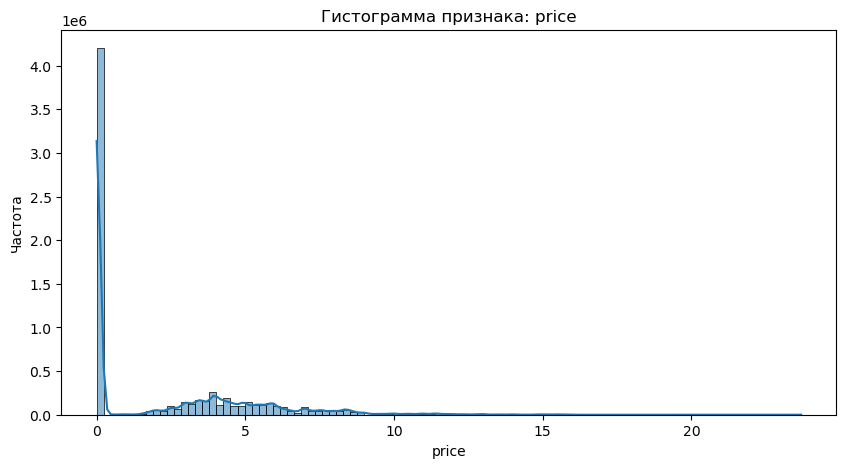

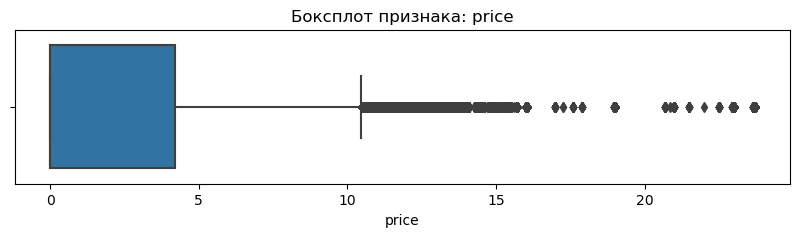

In [34]:
EDA(ana_sales, 'price', bins=100)

**Вывод**: необходимо избавится от случаев когда розничная цена равна 0 

In [35]:
ana_sales = ana_sales.query('price != 0')

Описательная статистика: price


count    3.039785e+06
mean     5.183818e+00
std      2.362352e+00
min      2.000000e-02
25%      3.590000e+00
50%      4.590000e+00
75%      6.190000e+00
max      2.369000e+01
Name: price, dtype: float64

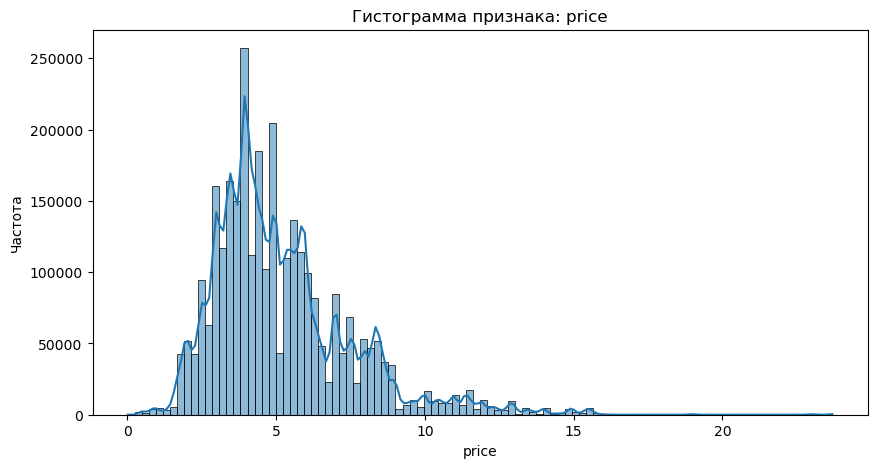

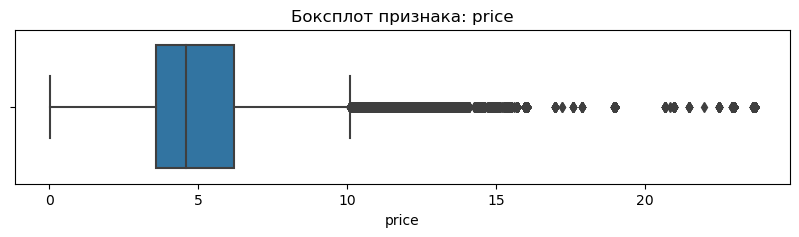

In [36]:
EDA(ana_sales, 'price', bins=100)

**Вывод**: гистограмма напоминает гауссовское распределение со смещением влево

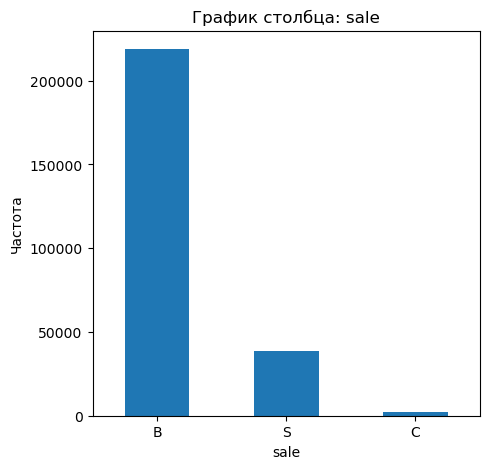

sale
B    218856
S     38778
C      2232
Name: count, dtype: int64


In [37]:
EDA_cat(ana_sales, 'sale')

**Вывод**: подавляющее количество акций были с бонусными покупками.

## Датасет `cig` 

In [38]:
cig_sales.head()

,store,upc,week,move,qty,price,sale
0,8,190,194,0,1,0.00,None
1,8,190,195,2,1,21.51,None
2,8,190,196,0,1,0.00,None
3,8,190,197,0,1,0.00,None
4,8,190,198,0,1,0.00,None


Описательная статистика: week


count    5.331369e+06
mean     2.288029e+02
std      1.070461e+02
min      1.000000e+00
25%      1.420000e+02
50%      2.370000e+02
75%      3.240000e+02
max      3.990000e+02
Name: week, dtype: float64

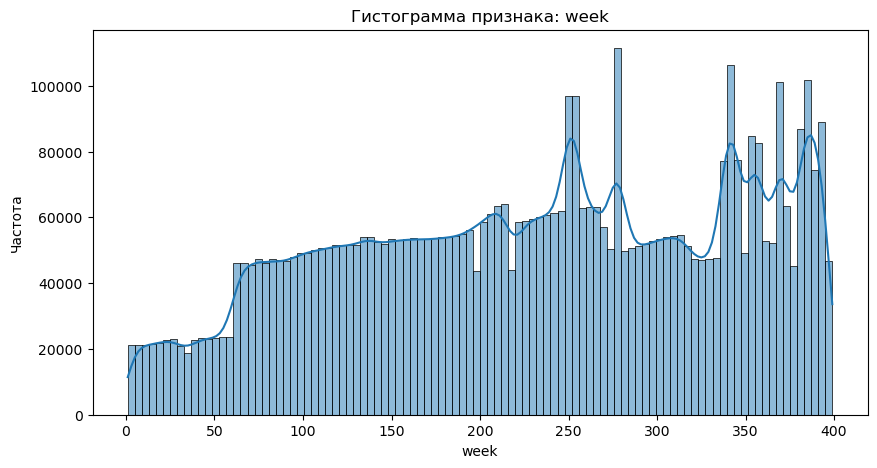

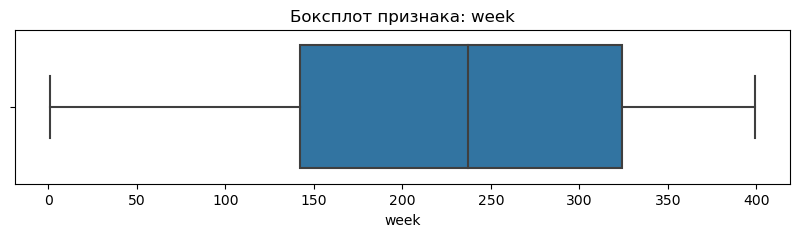

In [39]:
EDA(cig_sales, 'week', bins=100)

**Вывод**: наблюдается тенденция роста количества наблюдений с каждым годом

Описательная статистика: move


count    5.331369e+06
mean     2.900193e+00
std      4.203083e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      3.059000e+03
Name: move, dtype: float64

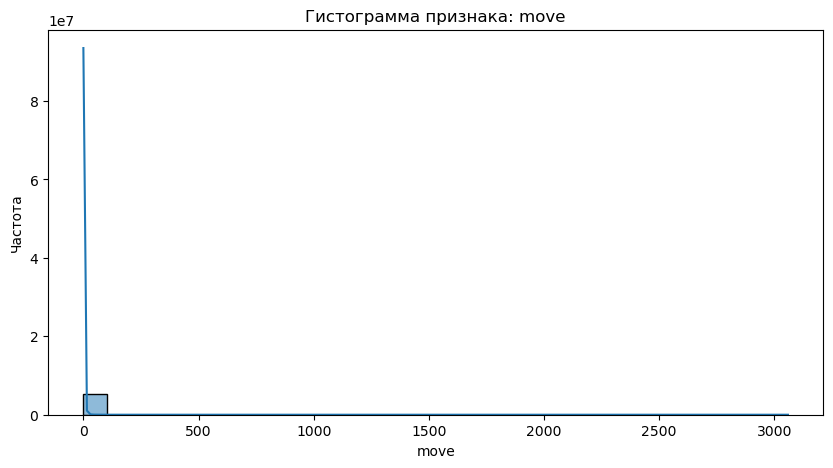

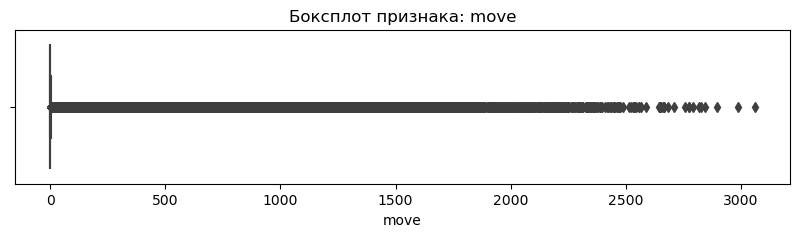

In [40]:
EDA(cig_sales, 'move')

**Вывод**: ситуация аналогична датасетам выше

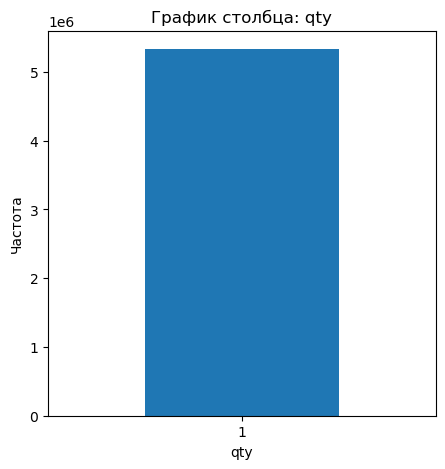

qty
1    5331369
Name: count, dtype: int64


In [41]:
EDA_cat(cig_sales, 'qty')

**Вывод**: все товары продавались не в комплекте

Описательная статистика: price


count    5.331369e+06
mean     2.599588e+00
std      5.882910e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      2.360000e+00
max      2.500000e+02
Name: price, dtype: float64

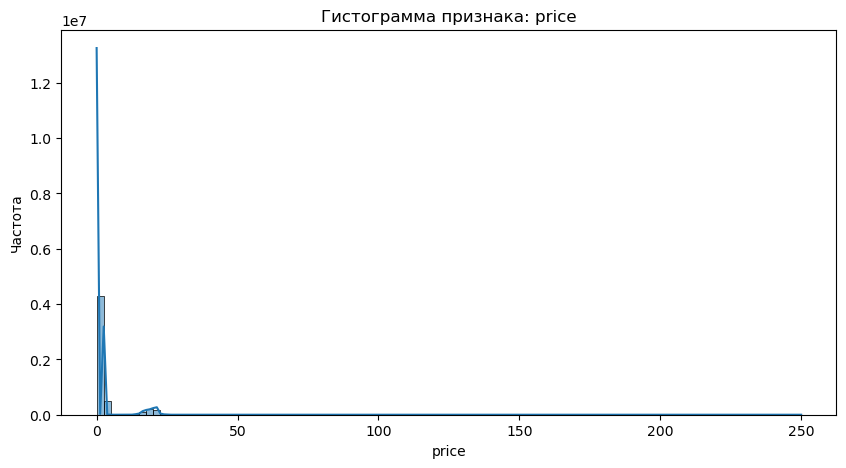

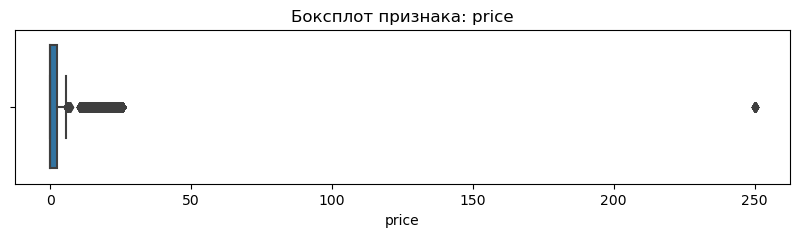

In [42]:
EDA(cig_sales, 'price', bins=100)

**Вывод**: наблюдаются аномальные значения: 0 и 250. Исключим их

In [43]:
cig_sales = cig_sales.query('0 < price < 200')

Описательная статистика: price


count    1.801444e+06
mean     7.689867e+00
std      7.898602e+00
min      1.000000e-02
25%      2.330000e+00
50%      2.580000e+00
75%      1.724000e+01
max      2.565000e+01
Name: price, dtype: float64

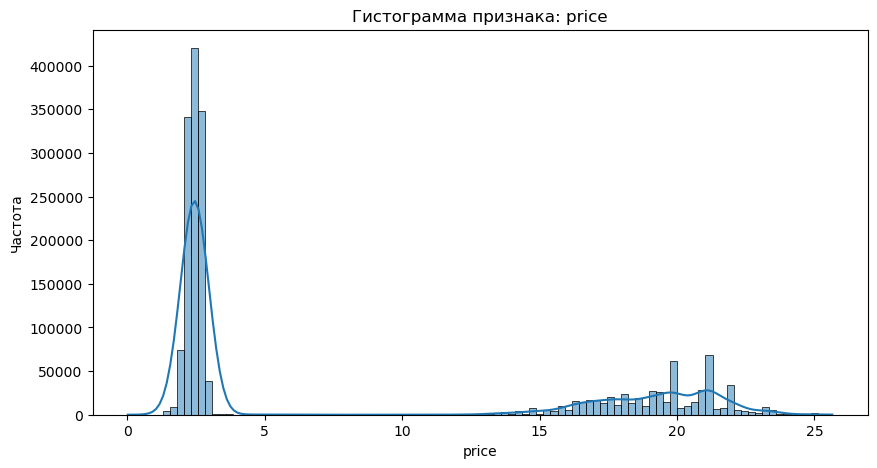

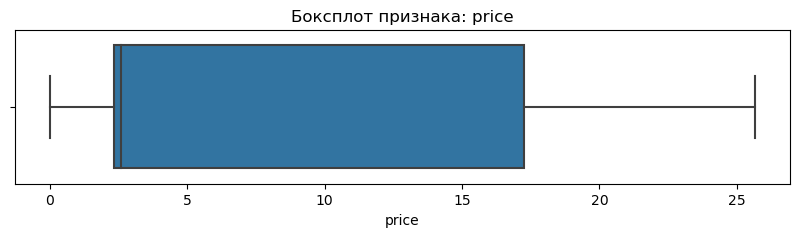

In [44]:
EDA(cig_sales, 'price', bins=100)

**Вывод**: распределение напоминает бимодальное. Скорее всего сигареты сильно разнятся по стоимости. Правый пик обоснован наличием таких премиальных и дорогих сигарет как Marlboro, Winston и Vogue, которые в США имеют стоимость около 20$ за пачку

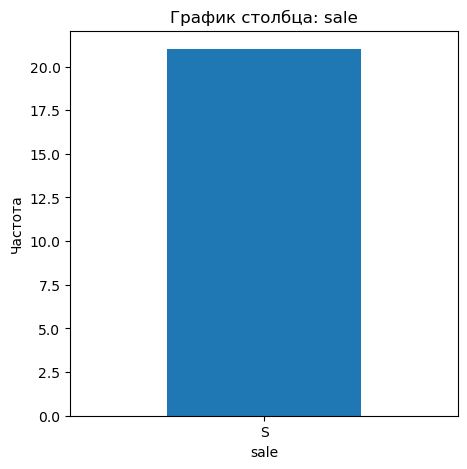

sale
S    21
Name: count, dtype: int64


In [45]:
EDA_cat(cig_sales, 'sale')

**Вывод**: Все акции были связаны с простым умешьнением стоимости товара

## Датасет `demographic`  

**Общий вывод**: исследовательский анализ окончен, все аномальные значения и выбросы исключены

# Подготовка датасета с анальгетиками

Начиная с этого шага исследование будет проводится только для анальгетиков

Теперь необходимо выделить отдельные признаки для  отдельных категорий товаров, проданных за каждую неделю, так как перед нами стоит задача *временных рядов*. Сгруппируем датасеты по признаку `week` проставим их по возрастанию и отберем признаки для этого. 

Датасет `demographic` игнорируем, в итоговый датасет добавим один единственный признак - деньги, которые выручили все магазины по всем товарам в категории. Для этого необходимо перемножить столбцы `move` (количество проданного товара) и `price` (розничная цена)

Подготовим датасет по анальгетикам

In [46]:
ana_sales.head()

,store,upc,week,move,qty,price,sale
1,76,1192603016,307,1,1,2.99,None
66,71,1192662108,286,1,1,4.49,None
152,98,1192662108,286,2,1,4.49,None
240,101,1192662108,288,1,1,4.49,None
324,121,1192662108,286,2,1,4.49,None


In [47]:
ana_sales.shape

(3039785, 7)

In [48]:
# Сортировка по неделе
ana_sales = ana_sales.sort_values('week')
ana_sales.head()

,store,upc,week,move,qty,price,sale
3230200,86,30573016020,1,5,1,2.68,B
2267555,101,30045047730,1,10,1,3.33,None
1054827,74,30009346303,1,3,1,4.19,None
4536204,93,31284310239,1,4,1,3.65,B
4512486,105,31284310238,1,3,1,3.37,None


In [49]:
# Добавление столбца с прибылью
ana_sales['gain'] = ana_sales['move'] * ana_sales['price']
ana_sales.head()

,store,upc,week,move,qty,price,sale,gain
3230200,86,30573016020,1,5,1,2.68,B,13.40
2267555,101,30045047730,1,10,1,3.33,None,33.30
1054827,74,30009346303,1,3,1,4.19,None,12.57
4536204,93,31284310239,1,4,1,3.65,B,14.60
4512486,105,31284310238,1,3,1,3.37,None,10.11


In [50]:
# Сброс ненужных столбцов
ana_sales = ana_sales.drop(['store', 'upc', 'move', 'qty', 'price', 'sale'], axis=1)
ana_sales.head()

,week,gain
3230200,1,13.40
2267555,1,33.30
1054827,1,12.57
4536204,1,14.60
4512486,1,10.11


Теперь необходимо перевести недели в временной интервал. Известно что датасеты сосатвлялиьс с 1989 по 1994 года. Будем считать 1989 год точкой отсчета.

In [51]:
ana_sales.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3039785 entries, 3230200 to 2601103
Data columns (total 2 columns):
 #   Column  Dtype  
---  ------  -----  
 0   week    int64  
 1   gain    float64
dtypes: float64(1), int64(1)
memory usage: 69.6 MB


In [52]:
start_date = datetime(1989, 1, 1)
ana_sales['week'] = ana_sales['week'].apply(lambda x: start_date + timedelta(weeks=x))

In [53]:
ana_sales['week'] = pd.to_datetime(ana_sales['week']) 

In [54]:
ana_sales = ana_sales.rename(columns={"week": "time"})
ana_sales.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3039785 entries, 3230200 to 2601103
Data columns (total 2 columns):
 #   Column  Dtype         
---  ------  -----         
 0   time    datetime64[ns]
 1   gain    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 69.6 MB


In [55]:
# Группировка по неделям
ana_sales = ana_sales.groupby(by='time').sum()
ana_sales.head()

,gain
time,
1989-01-08,78417.14
1989-01-15,81184.05
1989-01-22,81335.81
1989-01-29,82781.49
1989-02-05,80211.78


**Вывод**: датасет по анальгетикам готов, теперь у нас есть спрос на категорию анальгетиков за каждую неделю.

# Анализ временного ряда

Для начала выведем распределение

Описательная статистика: gain


count       392.000000
mean      97643.123036
std       12144.243410
min       56262.050000
25%       91844.660000
50%       97651.185000
75%      104701.090000
max      133000.330000
Name: gain, dtype: float64

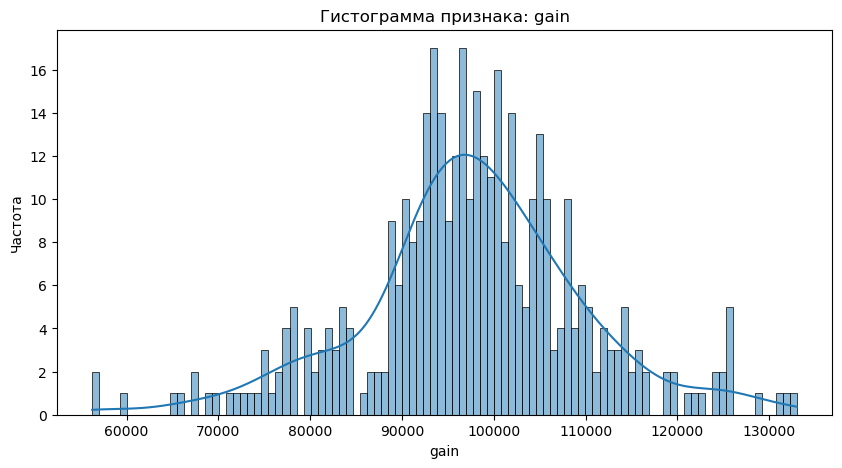

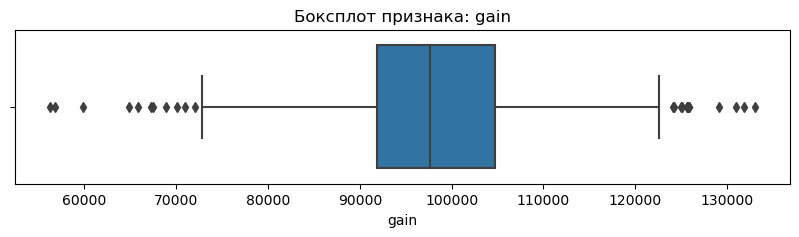

In [56]:
EDA(ana_sales, 'gain', bins=100)

**Вывод**: распределение напоминает нормальное без явных выбросов

Построим график данных вместе с скользящим средним

In [57]:
def rolling_mean(dataset): 
    plt.subplot(111)
    plt.plot(dataset, alpha=0.5)
    plt.plot(dataset.rolling(40).mean())
    plt.plot(dataset.rolling(40).std())
    plt.legend(['Общее распределение', 'Среднее', 'Стандартное отклонение'])
    plt.title('График распределения данных')
    plt.xlabel('Неделя')
    plt.ylabel('Прибыль')
    plt.show()

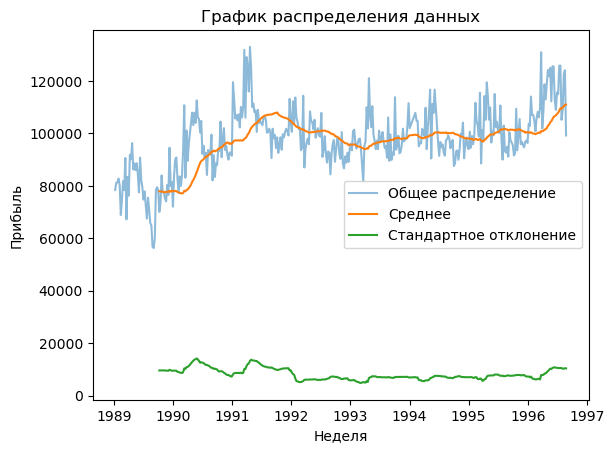

In [58]:
rolling_mean(ana_sales)

**Вывод**: Изначально спрос на анальгетики увеличивался (примерно до 100 недели), далее спрос вышел на плато и только в самом конце наметился тренд на увеличение спроса

Проведем анализ трендов, сезонности и шумов за разные промежутки времени

In [59]:
def trend_analysis(period): 
    '''Функция выводит графики составляющих определенного периода'''
    plt.figure(figsize=(10, 8))
    plt.subplot(311)
    plt.plot(period.trend)
    plt.xticks(rotation=45)
    plt.grid()
    plt.title('Трендовая составляющая')
    plt.show()
    
    plt.figure(figsize=(10, 8))
    plt.subplot(312)
    plt.plot(period.seasonal)
    plt.xticks(rotation=45)
    plt.grid()
    plt.title('Сезонная составляющая')
    plt.show()

    plt.figure(figsize=(10, 8))
    plt.subplot(313)
    plt.plot(period.resid)
    plt.xticks(rotation=45)
    plt.grid()
    plt.title('Шумы')
    plt.show()

Проведем анализ за год (с 1989 по 1990)

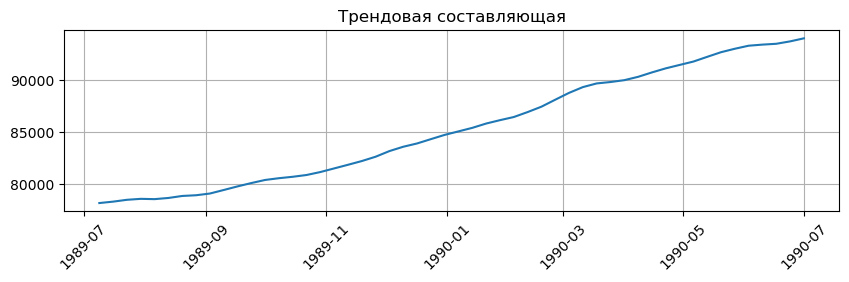

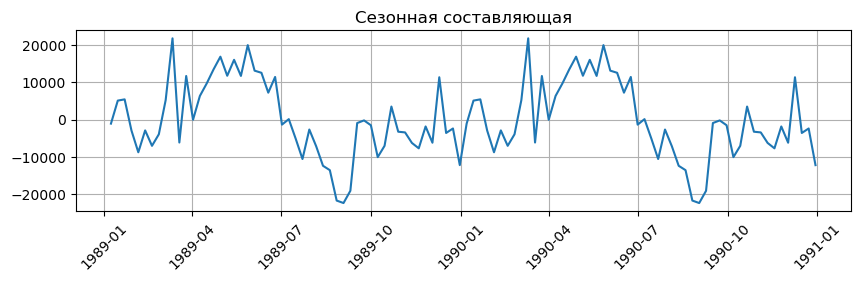

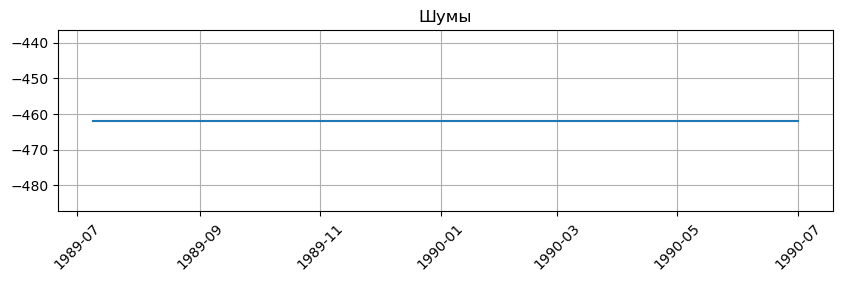

In [60]:
ana_year = ana_sales['1989-01-08':'1990-12-31']
ana_year = seasonal_decompose(ana_year)
trend_analysis(ana_year)

Увеличим диапазон наблюдений на 3 года (с 1989 по 1992)

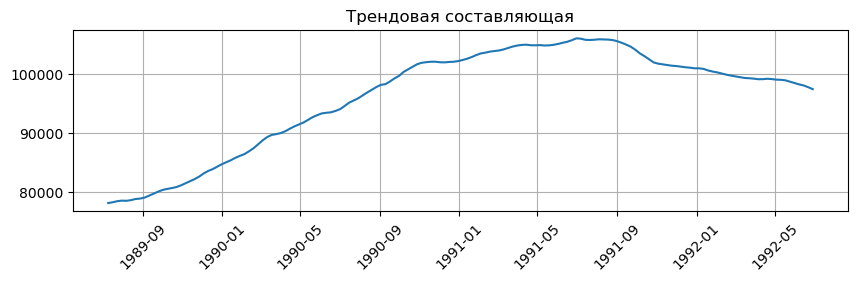

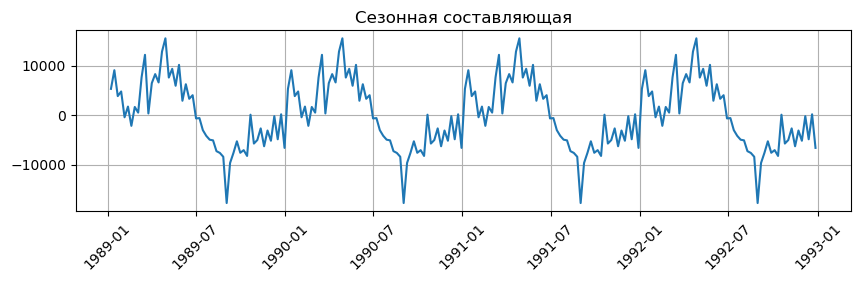

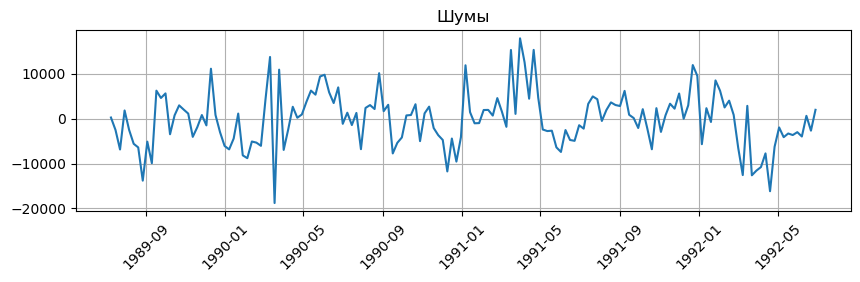

In [61]:
ana_5_year = ana_sales['1989-01-08':'1992']
ana_5_year = seasonal_decompose(ana_5_year)
trend_analysis(ana_5_year)

**Вывод**: Наблюдается тенденция спада спроса, однако теперь можно выделить сезонную составляющую на графике. Каждый год спрос изменяется по одному и тому же закону

# Корреляционный анализ 

Проведем автокорреляцию и определим значимые сдвиги.

In [62]:
ana_sales.head()

,gain
time,
1989-01-08,78417.14
1989-01-15,81184.05
1989-01-22,81335.81
1989-01-29,82781.49
1989-02-05,80211.78


In [63]:
def auto_corr(dataset, lags=10):
    fig, ax = plt.subplots(figsize=(30, 6))
    plot_acf(dataset, lags=lags, ax=ax)
#     plt.xticks(range(0, lags, 1)) 
    plt.show()

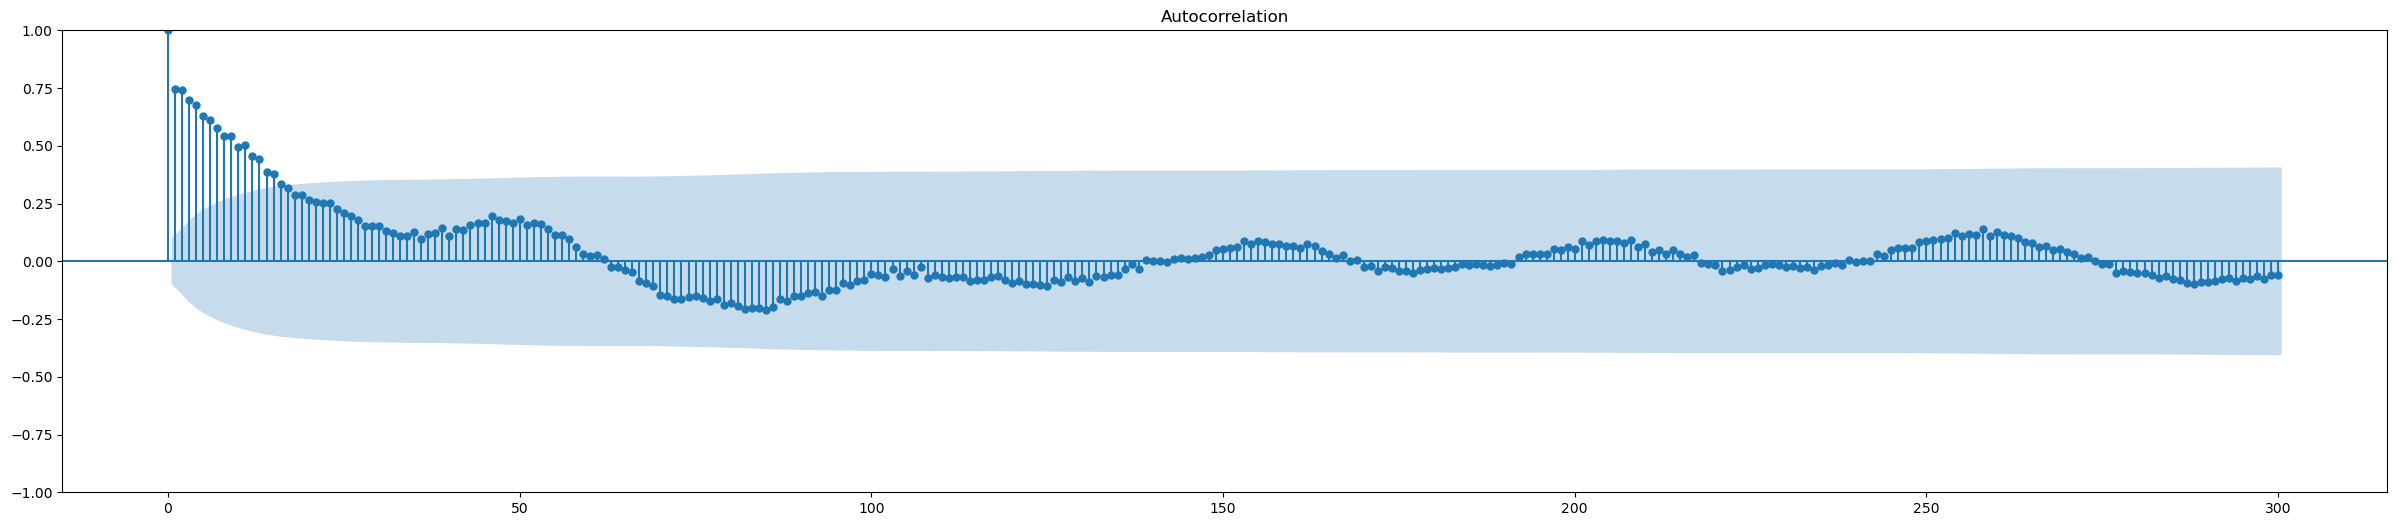

In [64]:
auto_corr(ana_sales, lags=300)

**Вывод**: данные начинают повторятся около 140го наблюдения (примерно через каждые 50-60 наблюдений, что и составляет примерно год, так как в году около 52 недель)

# Добавление признаков 

Необходимо создать признаки для горизонта прогнозирования в один шаг (1 неделя).

Добавим следующие параметры:
1. Сдвиг на одну неделю вперед
2. Скользящее среднее

In [65]:
# Сдвиг вперед
ana_sales['lag_1week'] = ana_sales['gain'].shift(1, fill_value=0)

In [66]:
ana_sales.head()

,gain,lag_1week
time,,
1989-01-08,78417.14,0.00
1989-01-15,81184.05,78417.14
1989-01-22,81335.81,81184.05
1989-01-29,82781.49,81335.81
1989-02-05,80211.78,82781.49


In [67]:
# Скользящее среднее
ana_sales['rolling_mean'] = ana_sales['gain'].shift(1).rolling(5).mean()

In [68]:
ana_sales = ana_sales.dropna()
ana_sales.head()

,gain,lag_1week,rolling_mean
time,,,
1989-02-12,68869.72,80211.78,80786.054
1989-02-19,74761.90,68869.72,78876.570
1989-02-26,81806.89,74761.90,77592.140
1989-03-05,78463.95,81806.89,77686.356
1989-03-12,90611.89,78463.95,76822.848


**Вывод**: необходимые признаки добавлены в датасет. Теперь можно приступать к разбиению на выборки и обучению моделей

# Разбиение на выборки

Для начала нужно определится с целевым признаком. Так как цель нашего прогнозирования - значение `gain`

In [69]:
train, test = train_test_split(ana_sales, shuffle=False, test_size=0.1)

In [70]:
target = 'gain'

X_train = train.drop(columns=target)
y_train = train[target]
X_test = test.drop(columns=target)
y_test = test[target]

In [71]:
X_train.head()

,lag_1week,rolling_mean
time,,
1989-02-12,80211.78,80786.054
1989-02-19,68869.72,78876.570
1989-02-26,74761.90,77592.140
1989-03-05,81806.89,77686.356
1989-03-12,78463.95,76822.848


In [72]:
y_train.head()

time
1989-02-12    68869.72
1989-02-19    74761.90
1989-02-26    81806.89
1989-03-05    78463.95
1989-03-12    90611.89
Name: gain, dtype: float64

**Вывод**: Выборки для обучения и тестирования готовы

# Обучение моделей

В качестве обучения возьмем несколько моделей с различными гиперпараметрами: 
- Ридж-регрессия
- Регрессия ближайщих соседей
- Регрессия дерева решений

Также используем следующие кодировщики: 
- Для количественных переменных: `StandardScaler` и `MinMaxScaler`

Получим наилучшую выборку при помощи кросс валидации `GridSearchCV`

За метрику возьмем `RMSE`

In [73]:
X_train.head()

,lag_1week,rolling_mean
time,,
1989-02-12,80211.78,80786.054
1989-02-19,68869.72,78876.570
1989-02-26,74761.90,77592.140
1989-03-05,81806.89,77686.356
1989-03-12,78463.95,76822.848


In [74]:
numerical_cols = ['lag_1week', 
                 'rolling_mean']

In [75]:
RANDOM_STATE = 1

Построим пайплайн для обучения модели

In [76]:
# обработка данных
data_preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_cols)
], 
    remainder='passthrough')

In [77]:
# Финальный пайплайн
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor), 
    ('models', Ridge(random_state=RANDOM_STATE))
])

In [78]:
# подбор моделей и гиперпараметров
param_grid = [
    {
        'models': [Ridge(random_state=RANDOM_STATE)],
        'models__alpha': np.arange(0.1, 2, 0.3), 
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), "passthrough"]
    },  
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), "passthrough"]
    }, 
    {
        'models': [KNeighborsRegressor()], 
        'models__n_neighbors': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), "passthrough"]
    }
]

В данном случае обычная кросс-валидация не подойдет, так как мы имеем дело с временным рядом. Необходимо воспользоваться разбиением с учетом временного цикла

In [79]:
# Кросс валидация
tscv = TimeSeriesSplit(n_splits=3)
grid = GridSearchCV(estimator=pipe_final, 
                       cv=tscv,
                       scoring = 'neg_root_mean_squared_error',
                       param_grid=param_grid)

In [80]:
# Обучение
grid.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['lag_1week',
                                                                          'rolling_mean'])])),
                                       ('models', Ridge(random_state=1))]),
             param_grid=[{'models': [Ridge(random_state=1)],
                          'models__alpha': array([0.1, 0....
                                                MinMaxScaler(),
                                                'passthrough']},
                         {'models': [DecisionTreeRegressor(random_state=1)],
                          'models__max_depth': range(2, 10),
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']},
                         {'models': [KNeighborsRegressor()],
                          'models__n_neighbors': range(2, 10),
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']}],
             scoring='neg_root_mean_squared_error')

In [81]:
best_metric = round(abs(grid.best_score_))
print(f'Метрика RMSE лучшей модели {best_metric}')

Метрика RMSE лучшей модели 6983


Данная метрия является удовлетворительной для наших требований

In [82]:
grid.best_params_

{'models': Ridge(random_state=1),
 'models__alpha': 0.1,
 'preprocessor__num': 'passthrough'}

Лучшая модель найдена, проверим ее качество на тестовой выборке

In [83]:
y_pred = grid.best_estimator_.predict(X_test)
RMSE = round(root_mean_squared_error(y_test, y_pred))
print(f'RMSE на тестовой выборке: {RMSE}')

RMSE на тестовой выборке: 8325


**Вывод**: Метрика качества модели показала неплохой результат на тестовой выборке. Принимаем данную модель за наилучшую 

# Интерпретация лучшей модели 

Составим интерпретацию наилучшей модели прогнозирования спроса

In [84]:
model = grid.best_estimator_.named_steps['models']

In [85]:
# Веса модели
weights = model.coef_
weights

array([0.19643321, 0.68144798])

In [86]:
# Таблица с признаками и весами
feature_weights = pd.DataFrame({'feature': X_train.columns, 
                               'weight': weights})

feature_weights = feature_weights.sort_values(by='weight', 
                                             ascending=False, 
                                             ignore_index=True)
feature_weights

,feature,weight
0,rolling_mean,0.681448
1,lag_1week,0.196433


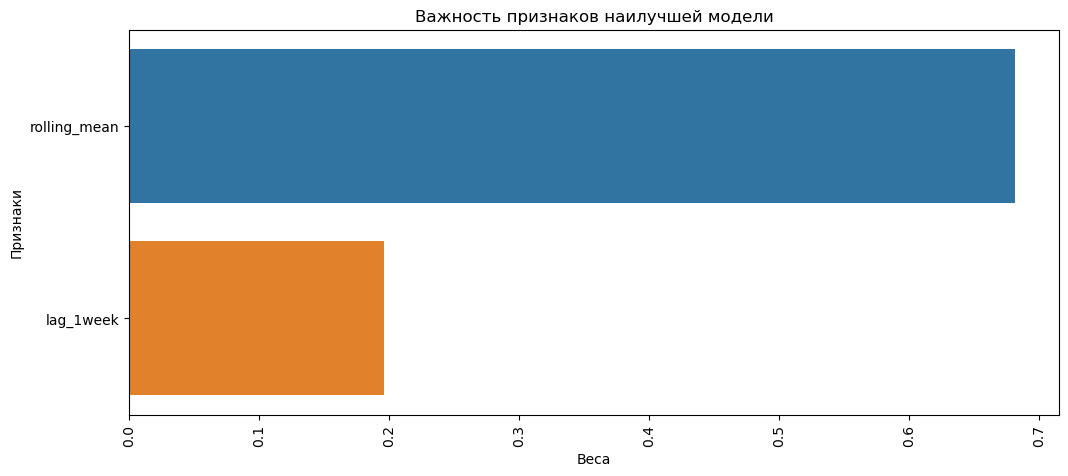

In [87]:
def feature_importance():
    plt.figure(figsize=(12, 5))
    sns.barplot(data=feature_weights, 
               x='weight', 
               y='feature')
    plt.xticks(rotation=90)
    plt.title('Важность признаков наилучшей модели')
    plt.xlabel('Веса')
    plt.ylabel('Признаки')
    plt.show()
    
feature_importance()

**Вывод**: наибольший вклад в предскзания модели внесло скользящее среднее

# Общий вывод

В ходе данной работы были выполнены следующие пункты: 
- Выгрузка и ознакомление с данными 
- Предобработка данных, корректировка признаков
- Ислледовательский анализ: исследовано распределение значений, а также тренды, сезонность и шумы
- Добавлены необходимые признаки для обучения моделей
- Обучены несколько моделей с различными гиперпараметрами и кодировщиками при помощи кросс-валидации

В результате чего наилучшей моделью оказалась Ридж-регрессия со следующими гиперпараметрами

In [88]:
print(grid.best_params_)

{'models': Ridge(random_state=1), 'models__alpha': 0.1, 'preprocessor__num': 'passthrough'}


In [89]:
print(f'Метрика RMSE на тестовой выборке показала результат {RMSE}')

Метрика RMSE на тестовой выборке показала результат 8325


Заказчику рекомендуется использовать данную модель с показанными выше кодировщиками и гиперпараметрами. 